In [16]:
# Import libraries and set desired options
%matplotlib inline
from matplotlib import pyplot as plt

import pickle
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [17]:
times = ['time'+str(i) for i in range(1,11)]
times

['time1',
 'time2',
 'time3',
 'time4',
 'time5',
 'time6',
 'time7',
 'time8',
 'time9',
 'time10']

In [18]:
# Read the training and test data sets and parse dates
train_df = pd.read_csv('train.csv',
                       index_col='session_id', parse_dates=times)

test_df = pd.read_csv('test.csv',
                      index_col='session_id', parse_dates=['time1'])

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:36,41475.0,2013-11-15 07:39:36,41476.0,2013-11-15 07:39:40,...,2013-11-15 07:39:41,6725.0,2013-11-15 07:42:50,41475.0,2013-11-15 07:42:50,41476.0,2013-11-15 07:42:50,6725.0,2013-11-15 07:44:25,0
81350,41476,2013-11-15 07:44:25,41475.0,2013-11-15 07:44:25,41476.0,2013-11-15 07:57:45,6725.0,2013-11-15 07:57:45,41475.0,2013-11-15 07:57:45,...,2013-11-15 07:57:46,41476.0,2013-11-15 07:57:47,6725.0,2013-11-15 07:57:49,41475.0,2013-11-15 07:57:49,41476.0,2013-11-15 07:57:49,0
234665,4802,2013-11-15 07:52:17,23.0,2013-11-15 07:52:18,4803.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:20,...,2013-11-15 07:52:20,4804.0,2013-11-15 07:52:23,21.0,2013-11-15 07:52:26,23.0,2013-11-15 07:52:26,22.0,2013-11-15 07:52:28,0
97610,23,2013-11-15 07:52:28,23.0,2013-11-15 07:52:29,22.0,2013-11-15 07:52:37,21.0,2013-11-15 07:52:37,63.0,2013-11-15 07:55:10,...,2013-11-15 07:55:10,784.0,2013-11-15 07:55:56,4804.0,2013-11-15 07:57:50,4804.0,2013-11-15 08:01:18,784.0,2013-11-15 08:01:26,0
161358,41476,2013-11-15 07:57:50,41476.0,2013-11-15 07:57:51,6725.0,2013-11-15 07:59:34,41475.0,2013-11-15 07:59:34,41476.0,2013-11-15 07:59:34,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [19]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site'+str(i) for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
    
# r before a string means "raw", i.e. take the string as it comes,
# e.g. as a file path without interpreting special symbols like \n

print('Websites total:', len(site_dict))



Websites total: 48371


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725,2013-11-15 07:39:35,6725,2013-11-15 07:39:36,41475,2013-11-15 07:39:36,41476,2013-11-15 07:39:40,...,2013-11-15 07:39:41,6725,2013-11-15 07:42:50,41475,2013-11-15 07:42:50,41476,2013-11-15 07:42:50,6725,2013-11-15 07:44:25,0
81350,41476,2013-11-15 07:44:25,41475,2013-11-15 07:44:25,41476,2013-11-15 07:57:45,6725,2013-11-15 07:57:45,41475,2013-11-15 07:57:45,...,2013-11-15 07:57:46,41476,2013-11-15 07:57:47,6725,2013-11-15 07:57:49,41475,2013-11-15 07:57:49,41476,2013-11-15 07:57:49,0
234665,4802,2013-11-15 07:52:17,23,2013-11-15 07:52:18,4803,2013-11-15 07:52:19,38,2013-11-15 07:52:19,38,2013-11-15 07:52:20,...,2013-11-15 07:52:20,4804,2013-11-15 07:52:23,21,2013-11-15 07:52:26,23,2013-11-15 07:52:26,22,2013-11-15 07:52:28,0
97610,23,2013-11-15 07:52:28,23,2013-11-15 07:52:29,22,2013-11-15 07:52:37,21,2013-11-15 07:52:37,63,2013-11-15 07:55:10,...,2013-11-15 07:55:10,784,2013-11-15 07:55:56,4804,2013-11-15 07:57:50,4804,2013-11-15 08:01:18,784,2013-11-15 08:01:26,0
161358,41476,2013-11-15 07:57:50,41476,2013-11-15 07:57:51,6725,2013-11-15 07:59:34,41475,2013-11-15 07:59:34,41476,2013-11-15 07:59:34,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0


In [22]:
site_dict

{'www.abmecatronique.com': 25075,
 'groups.live.com': 13997,
 'majeureliguefootball.wordpress.com': 42436,
 'cdt46.media.tourinsoft.eu': 30911,
 'www.hdwallpapers.eu': 8104,
 'img378.imageshack.us': 37491,
 'ecologie.nature.free.fr': 5462,
 'www.ibcn.intec.ugent.be': 35425,
 'kissanime.com': 30151,
 'www.carolineconduiteformation.com': 38268,
 'images.mystockphoto.com': 43641,
 'journalph.csphares.qc.ca': 36959,
 'www.uqo.ca': 40935,
 'd8d94e0wul1nb.cloudfront.net': 12346,
 'openapi.elong.com': 31023,
 'flamenco-o.blogspot.com': 31114,
 'www.pages-annuaire.net': 28165,
 'smart2000.pagesperso-orange.fr': 31877,
 'fast.forbes.com': 31070,
 'i1-js-14-3-01-10077-536503633-i.init.cedexis-radar.net': 12938,
 'i1-js-14-3-01-11074-716595896-i.init.cedexis-radar.net': 42002,
 'www.pacajob.com': 5671,
 'mathaa.epfl.ch': 32074,
 'cbv.sfr.bench.cedexis.com': 7104,
 'fbcdn-sphotos-b-a.akamaihd.net': 1939,
 'www.mystere-tv.com': 6708,
 'www.mon-ip.fr': 43589,
 'www.aqua-passion.com': 45241,
 'reunio

In [23]:
train_df[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
test_df[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                sep=' ', index=None, header=None)

In [24]:
%%time

vec = TfidfVectorizer(ngram_range=(1,5), max_features=50000)

with open('train_sessions_text.txt') as inp_train_file:
    X_train = vec.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = vec.transform(inp_test_file)

print(X_train.shape, X_test.shape)


(253561, 50000) (82797, 50000)
Wall time: 58.4 s


In [25]:
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [26]:
train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725,2013-11-15 07:39:35,6725,2013-11-15 07:39:36,41475,2013-11-15 07:39:36,41476,2013-11-15 07:39:40,...,2013-11-15 07:39:41,6725,2013-11-15 07:42:50,41475,2013-11-15 07:42:50,41476,2013-11-15 07:42:50,6725,2013-11-15 07:44:25,0
81350,41476,2013-11-15 07:44:25,41475,2013-11-15 07:44:25,41476,2013-11-15 07:57:45,6725,2013-11-15 07:57:45,41475,2013-11-15 07:57:45,...,2013-11-15 07:57:46,41476,2013-11-15 07:57:47,6725,2013-11-15 07:57:49,41475,2013-11-15 07:57:49,41476,2013-11-15 07:57:49,0
234665,4802,2013-11-15 07:52:17,23,2013-11-15 07:52:18,4803,2013-11-15 07:52:19,38,2013-11-15 07:52:19,38,2013-11-15 07:52:20,...,2013-11-15 07:52:20,4804,2013-11-15 07:52:23,21,2013-11-15 07:52:26,23,2013-11-15 07:52:26,22,2013-11-15 07:52:28,0
97610,23,2013-11-15 07:52:28,23,2013-11-15 07:52:29,22,2013-11-15 07:52:37,21,2013-11-15 07:52:37,63,2013-11-15 07:55:10,...,2013-11-15 07:55:10,784,2013-11-15 07:55:56,4804,2013-11-15 07:57:50,4804,2013-11-15 08:01:18,784,2013-11-15 08:01:26,0
161358,41476,2013-11-15 07:57:50,41476,2013-11-15 07:57:51,6725,2013-11-15 07:59:34,41475,2013-11-15 07:59:34,41476,2013-11-15 07:59:34,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129606,6003,2014-05-03 18:06:13,0,NaT,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
53628,6003,2014-05-03 18:09:26,0,NaT,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
84754,6003,2014-05-03 18:11:21,0,NaT,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0


In [27]:
train_df = train_df.sort_values(by='time1')

In [28]:
def add_features(time_df):
    start_hour = time_df['time1'].apply(lambda ts: ts.hour)
    add_data = pd.DataFrame(data=start_hour.values, columns=['start_hour'], index=start_hour.index)
    add_data['morning'] = ((start_hour >= 7) & (start_hour < 12)).astype('int').values.reshape(-1, 1) 
    add_data['day'] = ((start_hour >= 12) & (start_hour < 18)).astype('int').values.reshape(-1, 1) 
    add_data['evening'] = ((start_hour >= 18) & (start_hour <= 23)).astype('int').values.reshape(-1, 1) 
    add_data['night'] = ((start_hour >= 0) & (start_hour < 7)).astype('int').values.reshape(-1, 1) 
    add_data['week_day'] = time_df['time1'].apply(lambda ts: ts.weekday()).values.reshape(-1, 1)
    add_data['duration'] = (time_df.max(axis=1) - time_df.min(axis=1)).astype('timedelta64[s]')\
        .astype('int').values.reshape(-1, 1)
    add_data['month'] = time_df['time1'].apply(lambda ts: ts.month).astype('int').values.reshape(-1, 1)
    return add_data
    

In [35]:
add_train_df = add_features(train_df[times])
add_test_df = add_features(test_df[times])

In [36]:
add_train_df

,start_hour,morning,day,evening,night,week_day,duration,month
session_id,,,,,,,,
27554,7,1,0,0,0,4,290,11
81350,7,1,0,0,0,4,804,11
234665,7,1,0,0,0,4,11,11
97610,7,1,0,0,0,4,538,11
161358,7,1,0,0,0,4,104,11
...,...,...,...,...,...,...,...,...
129606,18,0,0,1,0,5,0,5
53628,18,0,0,1,0,5,0,5
84754,18,0,0,1,0,5,0,5


In [37]:
train_df.dtypes

site1              int32
time1     datetime64[ns]
site2              int32
time2     datetime64[ns]
site3              int32
time3     datetime64[ns]
site4              int32
time4     datetime64[ns]
site5              int32
time5     datetime64[ns]
site6              int32
time6     datetime64[ns]
site7              int32
time7     datetime64[ns]
site8              int32
time8     datetime64[ns]
site9              int32
time9     datetime64[ns]
site10             int32
time10    datetime64[ns]
target             int64
dtype: object

In [38]:
# add_train_df['duration'] = np.log1p(add_train_df['duration'])

In [39]:
# add_test_df['duration'] = np.log1p(add_test_df['duration'])

In [40]:
add_train_df.head()

,start_hour,morning,day,evening,night,week_day,duration,month
session_id,,,,,,,,
27554,7,1,0,0,0,4,290,11
81350,7,1,0,0,0,4,804,11
234665,7,1,0,0,0,4,11,11
97610,7,1,0,0,0,4,538,11
161358,7,1,0,0,0,4,104,11


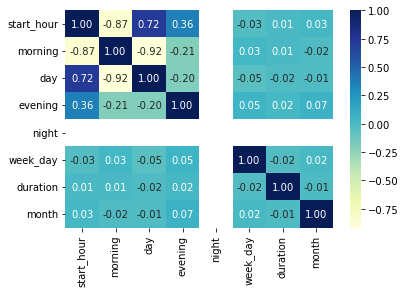

In [41]:
import seaborn as sns

corr = add_train_df.corr('spearman')
plt.figure()
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2f')

In [42]:
add_train_df.drop(columns=['night'], inplace=True)
add_test_df.drop(columns=['night'], inplace=True)

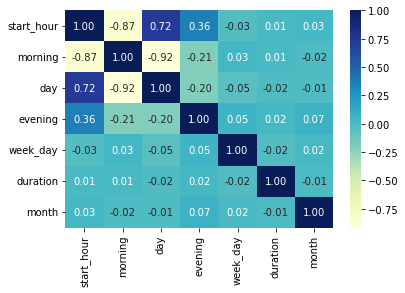

In [43]:
corr = add_train_df.corr('spearman')
plt.figure()
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2f')

In [44]:
add_train_dummies = pd.get_dummies(add_train_df, columns=['week_day'])
add_test_dummies = pd.get_dummies(add_test_df, columns=['week_day'])

In [45]:
add_train_dummies.head(5)

,start_hour,morning,day,evening,duration,month,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
session_id,,,,,,,,,,,,,
27554,7,1,0,0,290,11,0,0,0,0,1,0,0
81350,7,1,0,0,804,11,0,0,0,0,1,0,0
234665,7,1,0,0,11,11,0,0,0,0,1,0,0
97610,7,1,0,0,538,11,0,0,0,0,1,0,0
161358,7,1,0,0,104,11,0,0,0,0,1,0,0


In [46]:
from sklearn.preprocessing import StandardScaler
col_names = add_train_dummies.columns
scaler = StandardScaler()
for col in col_names:
    add_train_dummies[col] = scaler.fit_transform(add_train_dummies[col].values.reshape(-1, 1))
    add_test_dummies[col] = scaler.transform(add_test_dummies[col].values.reshape(-1, 1))

In [47]:
add_train_dummies.head()

,start_hour,morning,day,evening,duration,month,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
session_id,,,,,,,,,,,,,
27554,-1.673881,1.039061,-0.951532,-0.214457,0.512222,1.372553,-0.48753,-0.461049,-0.59097,-0.45811,2.379856,-0.192992,-0.120768
81350,-1.673881,1.039061,-0.951532,-0.214457,2.249993,1.372553,-0.48753,-0.461049,-0.59097,-0.45811,2.379856,-0.192992,-0.120768
234665,-1.673881,1.039061,-0.951532,-0.214457,-0.431043,1.372553,-0.48753,-0.461049,-0.59097,-0.45811,2.379856,-0.192992,-0.120768
97610,-1.673881,1.039061,-0.951532,-0.214457,1.350680,1.372553,-0.48753,-0.461049,-0.59097,-0.45811,2.379856,-0.192992,-0.120768
161358,-1.673881,1.039061,-0.951532,-0.214457,-0.116621,1.372553,-0.48753,-0.461049,-0.59097,-0.45811,2.379856,-0.192992,-0.120768


In [48]:
add_test_dummies.head()

,start_hour,morning,day,evening,duration,month,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
session_id,,,,,,,,,,,,,
1,-0.407823,1.039061,-0.951532,-0.214457,-0.444566,-0.302693,-0.487530,-0.461049,-0.59097,2.182883,-0.420193,-0.192992,-0.120768
2,-0.407823,1.039061,-0.951532,-0.214457,-0.180858,-0.542014,-0.487530,-0.461049,-0.59097,-0.458110,2.379856,-0.192992,-0.120768
3,0.858234,-0.962408,1.050937,-0.214457,-0.184239,-0.063372,2.051154,-0.461049,-0.59097,-0.458110,-0.420193,-0.192992,-0.120768
4,-0.724338,1.039061,-0.951532,-0.214457,-0.454709,-0.302693,-0.487530,-0.461049,-0.59097,-0.458110,2.379856,-0.192992,-0.120768
5,0.858234,-0.962408,1.050937,-0.214457,-0.424281,-0.063372,-0.487530,-0.461049,-0.59097,-0.458110,2.379856,-0.192992,-0.120768


In [49]:
add_train_dummies.shape, add_test_dummies.shape

((253561, 13), (82797, 13))

In [51]:
from scipy.sparse import csr_matrix, hstack

X_train_full = csr_matrix(hstack([X_train, add_train_dummies.values]))
X_test_full = csr_matrix(hstack([X_test, add_test_dummies.values]))

In [52]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    
    # Classifier training
    lr = LogisticRegressionCV(cv=10, n_jobs=-1, random_state=seed, scoring='roc_auc', verbose=3, max_iter=500).fit(X[:idx, :], y[:idx])
    
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [53]:
# Our target variable
y_train = train_df['target'].values

In [54]:
print(get_auc_lr_valid(X_train_full, y_train))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  8.3min remaining: 19.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  8.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.5min finished


0.978941585873078


In [70]:
# 50% of train data for training:

get_auc_lr_valid(X_train, y_train, ratio=0.5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  3.2min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.4min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.4min finished


0.8497328369060202

In [55]:
# 50% of train data for training:

get_auc_lr_valid(X_train, y_train, ratio=0.5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.6min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.7min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.5min finished


0.8497328369060202

In [56]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = range(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [57]:
# Train the model on the whole training data set
# Use random_state=17 for reproducibility
# Parameter C=1 by default, but here we set it explicitly

lr = LogisticRegressionCV(cv=5, verbose=3, n_jobs=-1, random_state=17, scoring='roc_auc', max_iter=500).fit(X_train_full,\
                                                                                                            y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
# Make a prediction for test data set
y_test = lr.predict_proba(X_test_full)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')